In [65]:
import pickle
import pandas as pd
from pathlib import Path

root = Path("/home/kkumbier/als/scripts/maps/")
result_dir = root / "template_analyses/multimarker_multiclass/3-class"
#response_map = {"WT": 0, "FUS": 1, "SOD1": 2, "C9orf72": 3}
response_map = {"WT": 0, "FUS": 1, "SOD1": 2}
antibodies = ["HSP70/SOD1", "FUS/EEA1", "COX IV/Galectin3/atubulin"]

with open(result_dir / "train_test_predictions.pkl", "rb") as f:
    results = pickle.load(f)

df = results["df"]
df_sporadic = df[df["Label"] == len(response_map)].copy()
df = df[df["Label"] != len(response_map)]

df_full = results["df_full"]
df_full = df_full.rename(columns={"True": "Label"})
df_full_sporadic = df_full[df_full["Label"] == len(response_map)].copy()
df_full = df_full[df_full["Label"] != len(response_map)]

In [60]:
from maps.utils import conformal_prediction_sets

if "PredictionSet" not in df.columns:
    conformal_sets = conformal_prediction_sets(df, 0.9)
    conformal_sets = conformal_sets[["CellLines", "PredictionSet"]]
    df = pd.merge(df, conformal_sets, how="inner", on="CellLines")

# Reformat data for barplot viz
class_names = {v:k for k, v in response_map.items()}
prob_cols = [f"prob_{i}" for i in range(len(class_names))] 
plot_data_list = []

for _, row in df.iterrows():
    cellline = row['CellLines']
    true_class = int(row['Label'])
    
    # Get probabilities for all classes
    probs = [row[col] for col in prob_cols]
    
    # Create a row for each class probability
    for class_idx, prob in enumerate(probs):
        plot_data_list.append({
            'CellLine': cellline,
            'TrueClass': class_names.get(true_class, f'Class_{true_class}'),
            'PredictedClass': class_names.get(class_idx, f'Class_{class_idx}'),
            'Probability': prob,
            'TrueClassProb': probs[true_class],  
            'ClassIndex': class_idx,
            "PredictionSet":row["PredictionSet"]
        })

plot_df = pd.DataFrame(plot_data_list)

/tmp/ipykernel_850403/3994947762.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


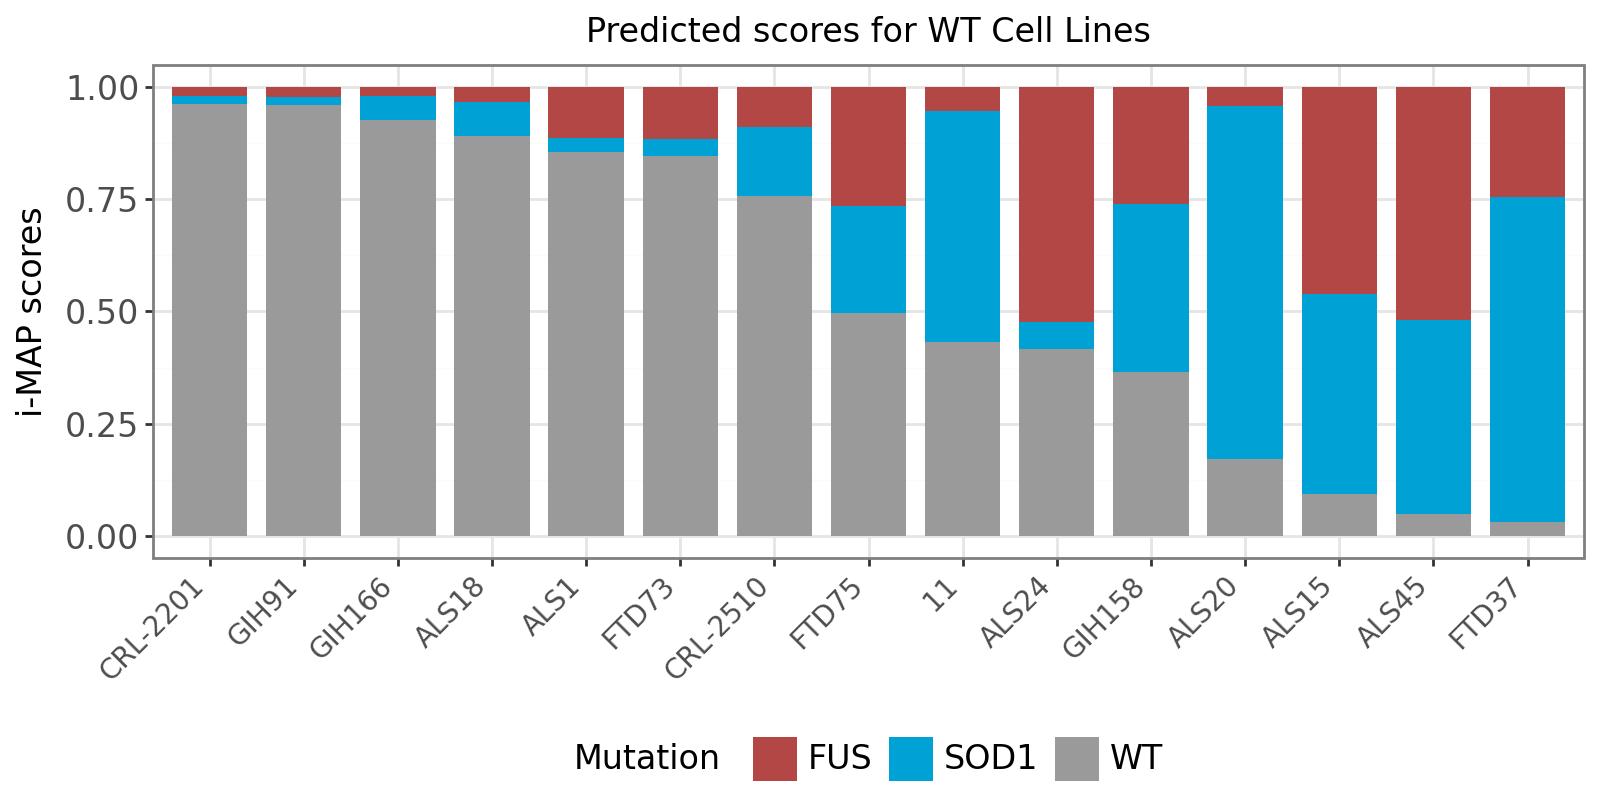

/tmp/ipykernel_850403/3994947762.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


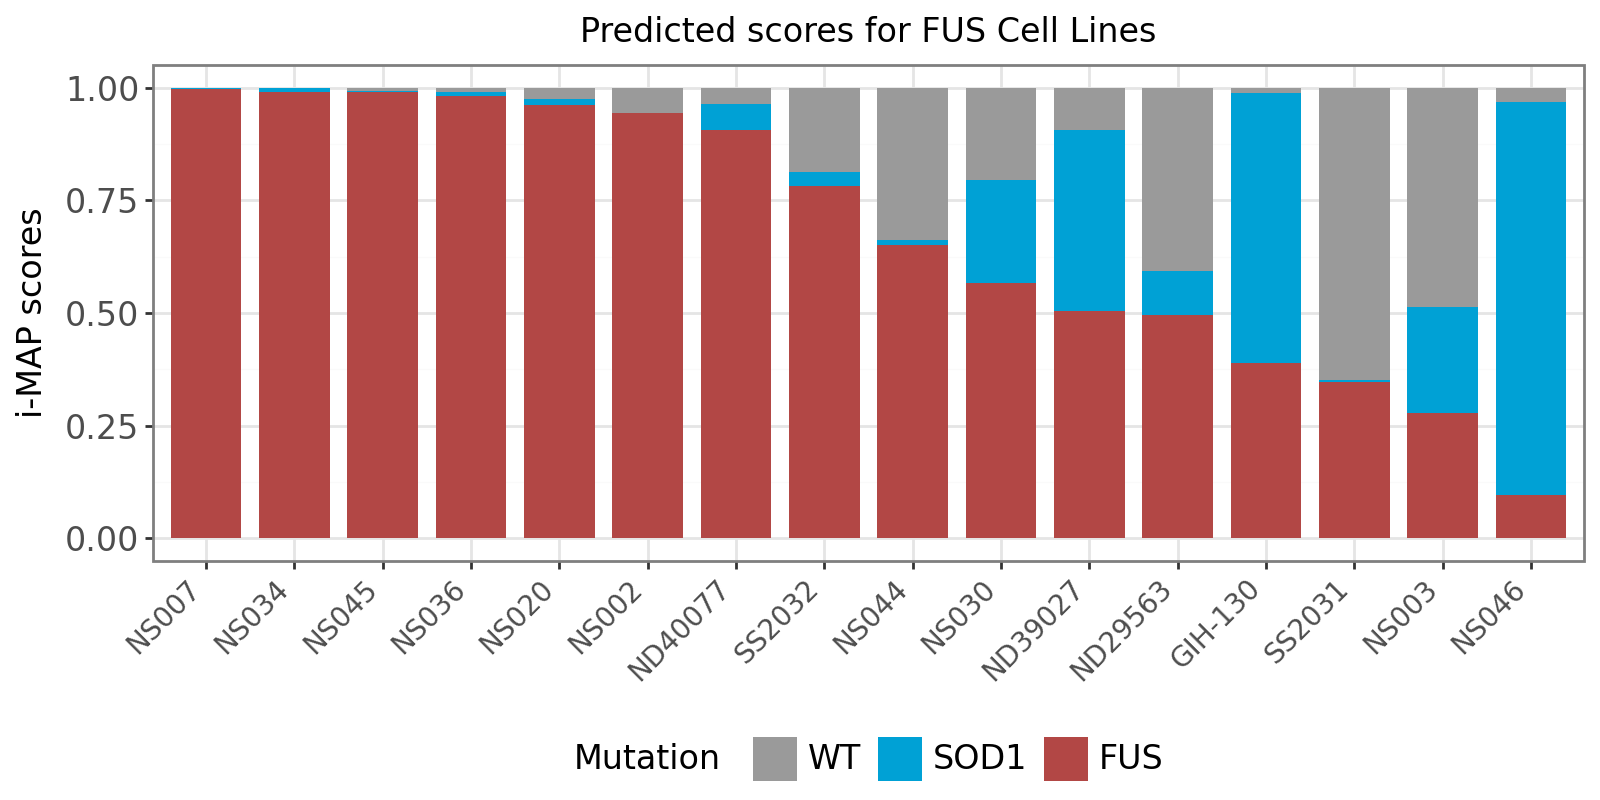

/tmp/ipykernel_850403/3994947762.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


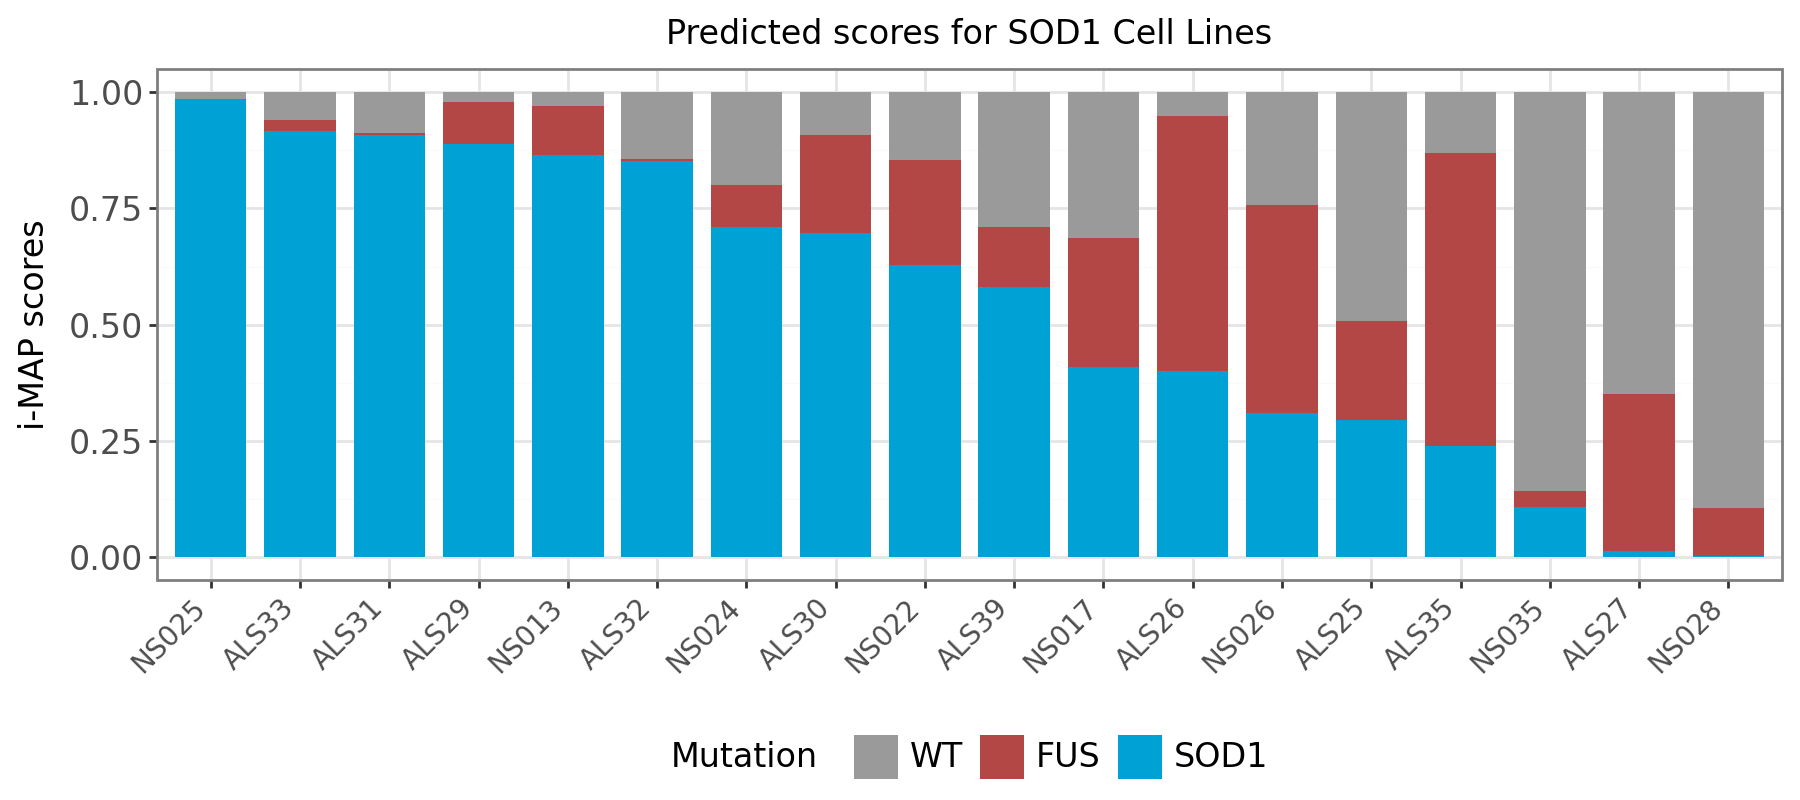

In [66]:
# Create stacked barplots for each true class category
from plotnine import *
from maps.figures import PALETTE

# Create a separate plot for each true class
for true_class in plot_df['TrueClass'].unique():
    # Filter data for this true class
    class_data = plot_df[plot_df['TrueClass'] == true_class].copy()
    
    # Sort celllines by their true class probability (descending)
    cellline_order = (
        class_data.groupby('CellLine')['TrueClassProb']
            .first()
            .sort_values(ascending=False)
            .index.tolist()
    )
    
    # Make CellLine categorical with the sorted order
    class_data['CellLine'] = pd.Categorical(
        class_data['CellLine'], 
        categories=cellline_order, 
        ordered=True
    )
    
    # Reorder PredictedClass so true class appears first
    class_order = [cls for cls in response_map.keys() if cls != true_class] 
    class_order += [true_class]
    class_data['PredictedClass'] = pd.Categorical(
        class_data['PredictedClass'],
        categories=class_order,
        ordered=True
    )
    
    # Sort the data by PredictedClass to ensure proper stacking order
    class_data = class_data.sort_values('PredictedClass')
    
    # Create data for text labels (one per cellline)
    text_data = class_data.groupby('CellLine').agg({
        'PredictionSet': 'first'
    }).reset_index()
    text_data['PredictionSetStr'] = text_data['PredictionSet'].apply(
        lambda x: ", ".join(class_names[int(i)][0] for i in x)
    )
    
    text_data['y_position'] = 1.05  # Position slightly above the bars
    
    # Create the stacked bar plot
    p = (
        ggplot(class_data, aes(x='CellLine', y='Probability', fill='PredictedClass')) +
        geom_col(position='stack', width=0.8) +
        #geom_text(data=text_data, mapping=aes(x='CellLine', y='y_position', label='PredictionSetStr'), 
        #         size=8, angle=45, inherit_aes=False) +
        scale_fill_manual(values=PALETTE, name='Mutation') +
        scale_x_discrete() +
        #scale_y_continuous(limits=[0, 1.2]) + 
        theme_bw() +
        theme(
            text=element_text(size=12),
            figure_size=(max(8, len(cellline_order) * 0.5), 4),
            axis_text_x=element_text(angle=45, hjust=1, size=10),
            legend_position='bottom'
        ) +
        labs(
            title=f'Predicted scores for {true_class} Cell Lines',
            x='',
            y='i-MAP scores',
        ) +
        guides(fill=guide_legend(ncol=4))
    )
    
    display(p)

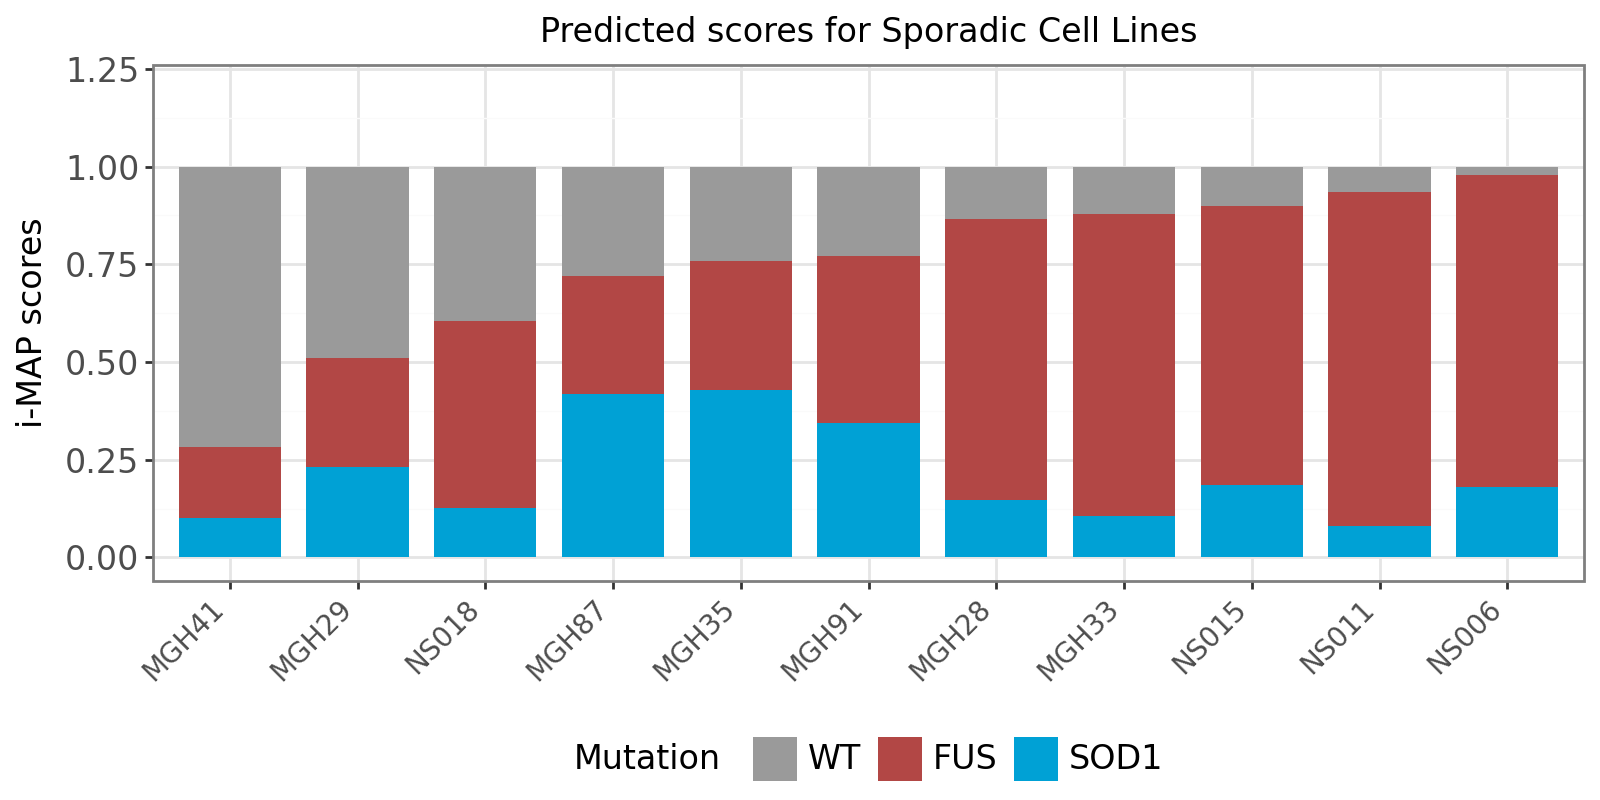

In [69]:
# Create stacked barplots for sporadic samples
from plotnine import *
from maps.figures import PALETTE

# Prepare sporadic data in the same format as plot_df
plot_data_list_sporadic = []

for _, row in df_sporadic.iterrows():
    cellline = row['CellLines']
    
    # Get probabilities for all classes
    probs = [row[f'prob_{i}'] for i in range(len(class_names))]
    
    # Create a row for each class probability
    for class_idx, prob in enumerate(probs):
        plot_data_list_sporadic.append({
            'CellLine': cellline,
            'TrueClass': 'Sporadic',
            'PredictedClass': class_names.get(class_idx, f'Class_{class_idx}'),
            'Probability': prob,
            'ClassIndex': class_idx
        })

plot_df_sporadic = pd.DataFrame(plot_data_list_sporadic)

# Create stacked barplot for sporadic samples
sporadic_data = plot_df_sporadic.copy()

# Sort celllines by their WT class probability (descending) or any other metric
cellline_order = (sporadic_data[sporadic_data['PredictedClass'] == 'WT']
                 .sort_values('Probability', ascending=False)['CellLine']
                 .unique().tolist())

# Make CellLine categorical with the sorted order
sporadic_data['CellLine'] = pd.Categorical(
    sporadic_data['CellLine'], 
    categories=cellline_order, 
    ordered=True
)

# Order PredictedClass
class_order = list(response_map.keys())
sporadic_data['PredictedClass'] = pd.Categorical(
    sporadic_data['PredictedClass'],
    categories=class_order,
    ordered=True
)

# Sort the data by PredictedClass to ensure proper stacking order
sporadic_data = sporadic_data.sort_values('PredictedClass')

# Create the stacked bar plot
p = (
    ggplot(sporadic_data, aes(x='CellLine', y='Probability', fill='PredictedClass')) +
    geom_col(position='stack', width=0.8) +
    scale_fill_manual(values=PALETTE, name='Mutation') +
    scale_x_discrete() +
    scale_y_continuous(limits=[0, 1.2]) +  # Expand y-axis
    theme_bw() +
    theme(
        text=element_text(size=12),
        figure_size=(max(8, len(cellline_order) * 0.5), 4),
        axis_text_x=element_text(angle=45, hjust=1, size=10),
        legend_position='bottom'
    ) +
    labs(
        title=f'Predicted scores for Sporadic Cell Lines',
        x='',
        y='i-MAP scores',
    ) +
    guides(fill=guide_legend(ncol=4))
)

display(p)

In [68]:
import re
import numpy as np

def get_qt_thresh(df, quantile=[0.9]):
    # Find all class probability columns
    prob_cols = [col for col in df.columns if re.match(r'prob_.*', col)]
    classes = [col.replace('prob_', '') for col in prob_cols]
    
    # Compute nonconformity scores for calibration set
    def get_nonconformity(row):
        return 1 - row[f'prob_{row["Label"]}']
   
    cal_df = df.copy() 
    cal_df['nonconformity'] = cal_df.apply(get_nonconformity, axis=1)
    
    quantile = np.clip(
        [q * (len(cal_df) + 1) / len(cal_df) for q in quantile], 0, 1 
    ) 
    
    return cal_df['nonconformity'].quantile(quantile)   

In [55]:
prob_cols = [f"prob_{i}" for i in range(len(class_names))]
k = len(prob_cols)  # Number of classes
conformal_qts = get_qt_thresh(df, quantile=[0.75, 0.9])
grid_dict = {}

# Recursive function to generate all combinations of n_vars that sum to total
def generate_combinations(n_vars, total, step=0.01, current=[]):
    """Generate all combinations of n_vars non-negative values that sum to total."""
    if n_vars == 1:
        val = round(total, 2)
        if val >= -0.01:  # Allow small floating point errors
            yield current + [max(0, val)]
    else:
        # Generate values from 0 to total in steps
        for val in np.arange(0, total + step, step):
            val = round(val, 2)
            if val <= total + 0.01:
                yield from generate_combinations(n_vars - 1, total - val, step, current + [val])

# Create grids for all permutations of which column gets the threshold
for qt in conformal_qts:
    # For each permutation of which column gets >= threshold value
    for threshold_col in range(k):
        grid_data = []
        remaining_cols = [i for i in range(k) if i != threshold_col]
        
        # Allow threshold column to take any value >= qt, up to 1.0
        for threshold_val in np.arange(qt, 1.0 + 0.01, 0.01):
            threshold_val = round(threshold_val, 2)
            remaining = round(1.0 - threshold_val, 2)
            
            # Generate all combinations for k-1 free variables that sum to remaining
            for vals in generate_combinations(k - 1, remaining, step=0.01):
                probs = [0] * k
                probs[threshold_col] = threshold_val
                for col_idx, val in zip(remaining_cols, vals):
                    probs[col_idx] = val
                
                grid_data.append({f'prob_{i}': probs[i] for i in range(k)})
        
        # Store with key (threshold, column_index)
        grid_dict[(qt, threshold_col)] = pd.DataFrame(grid_data)

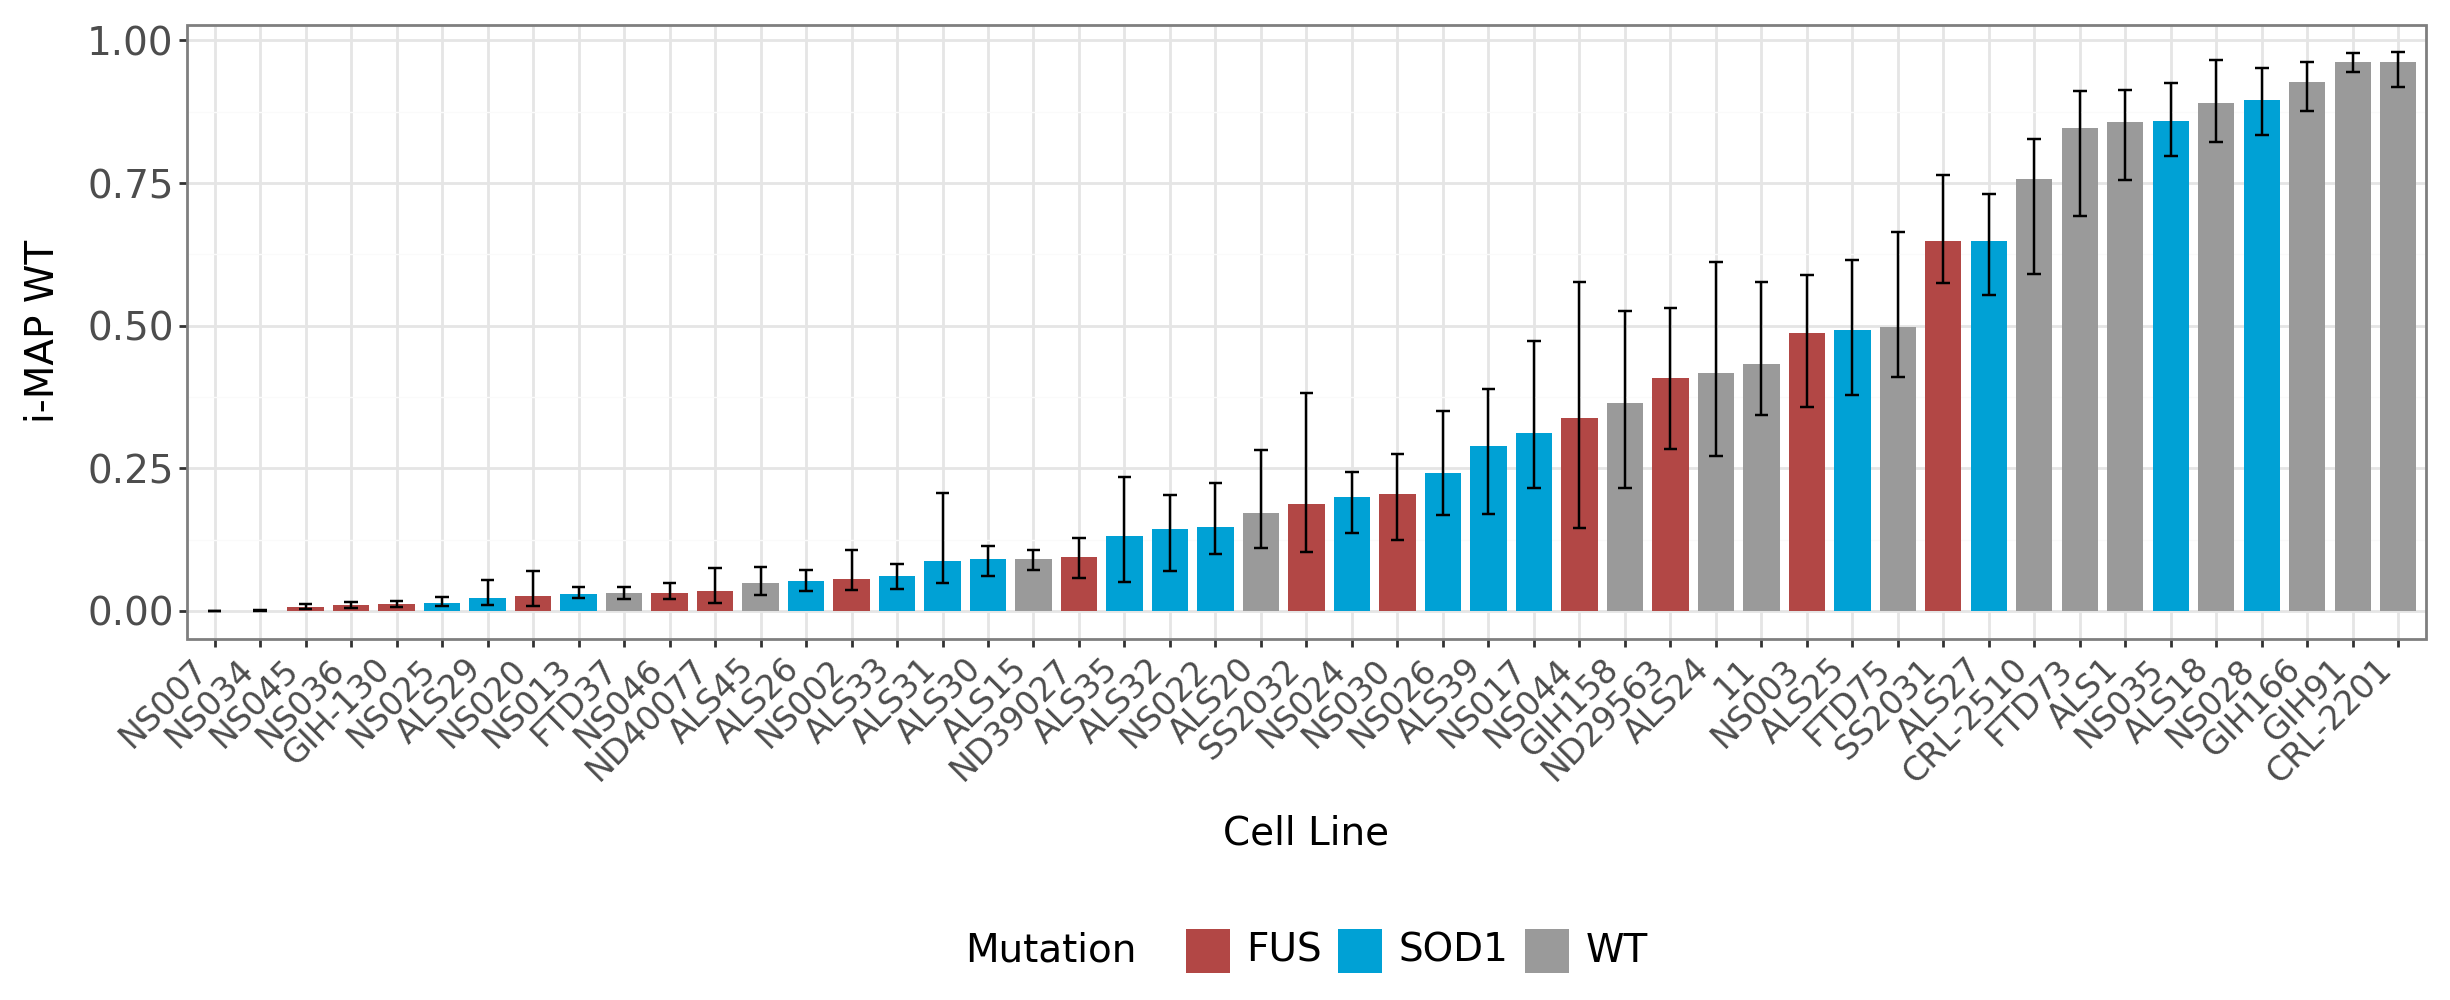

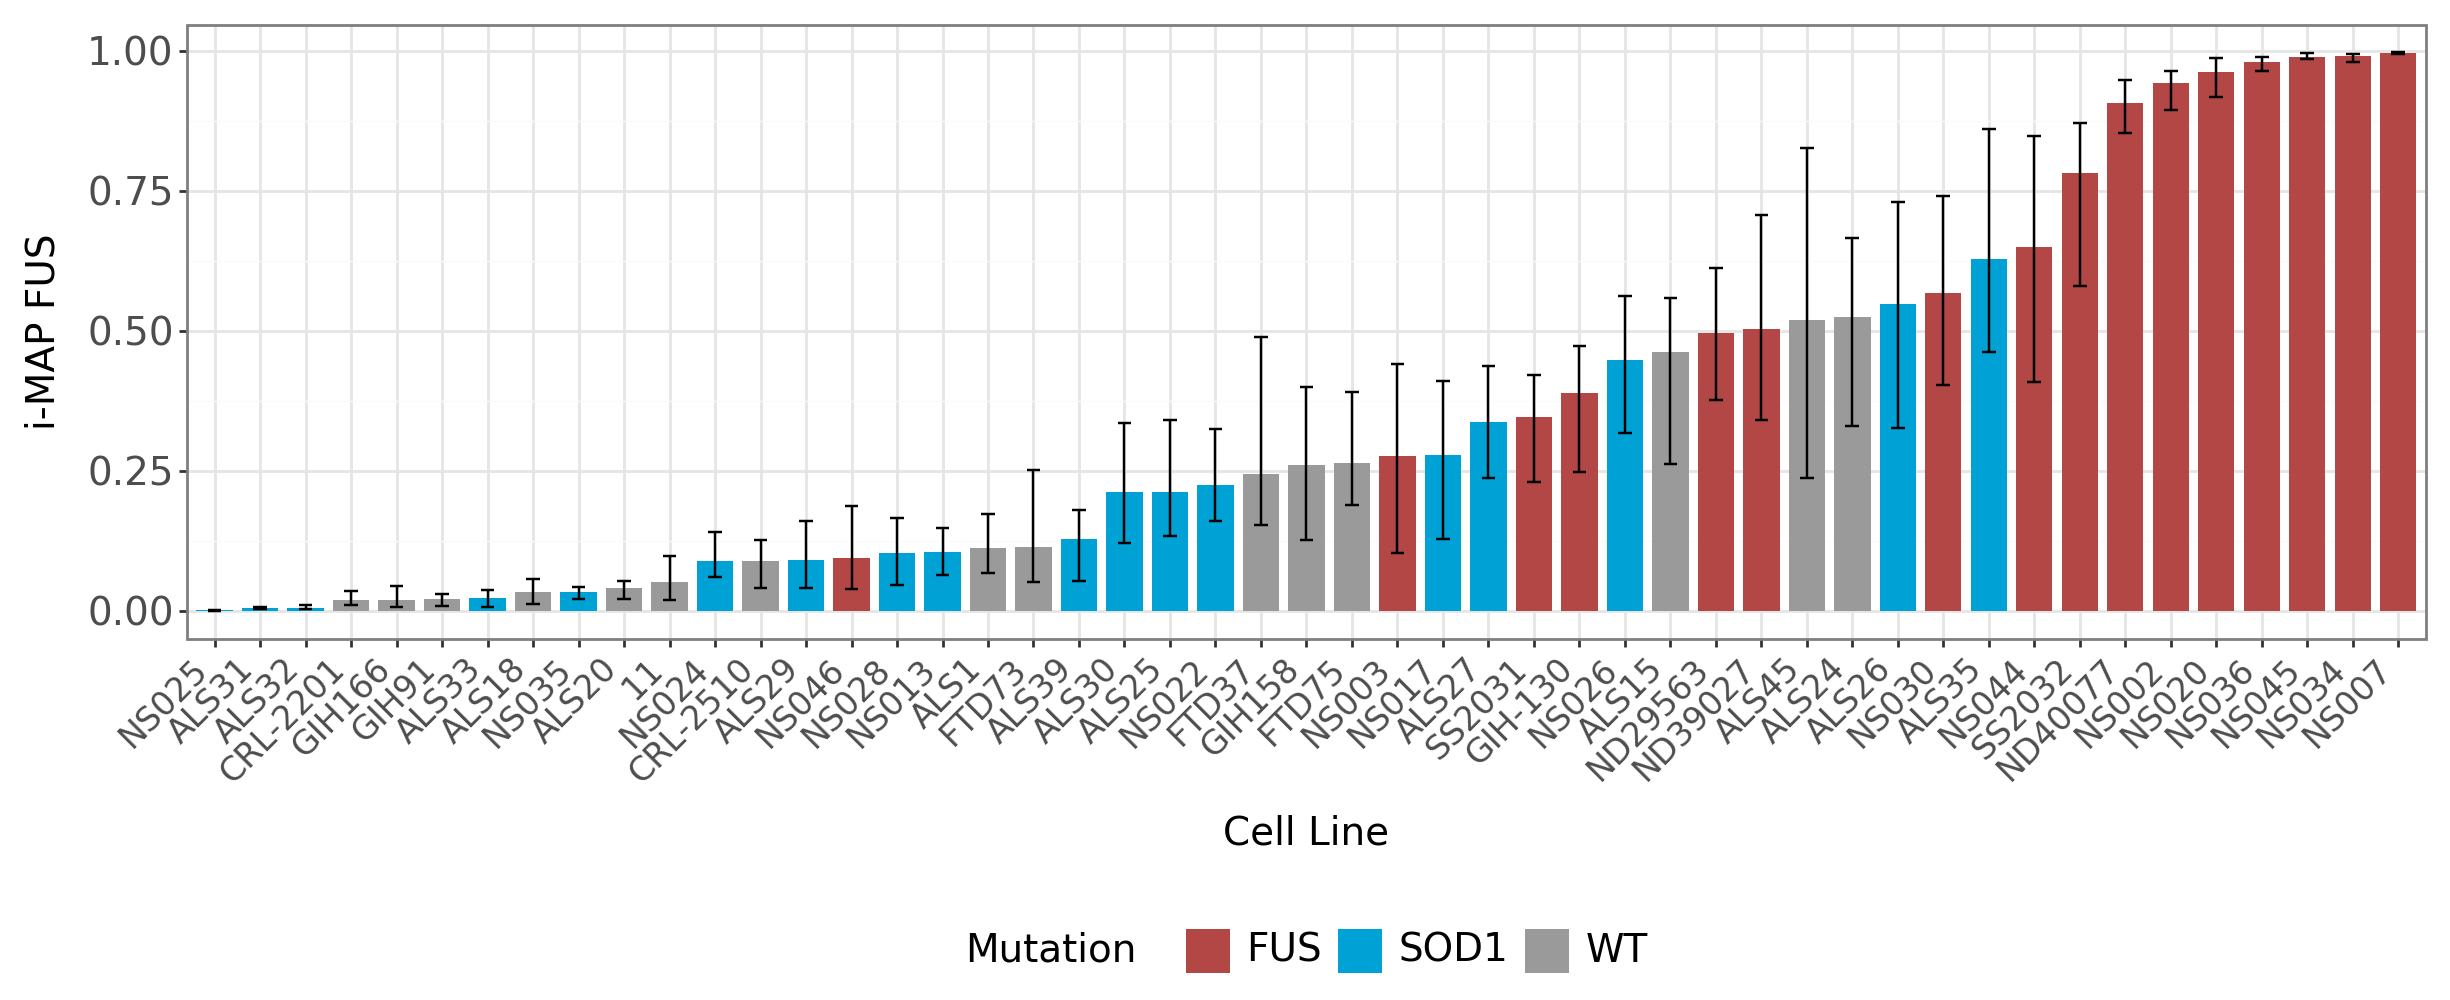

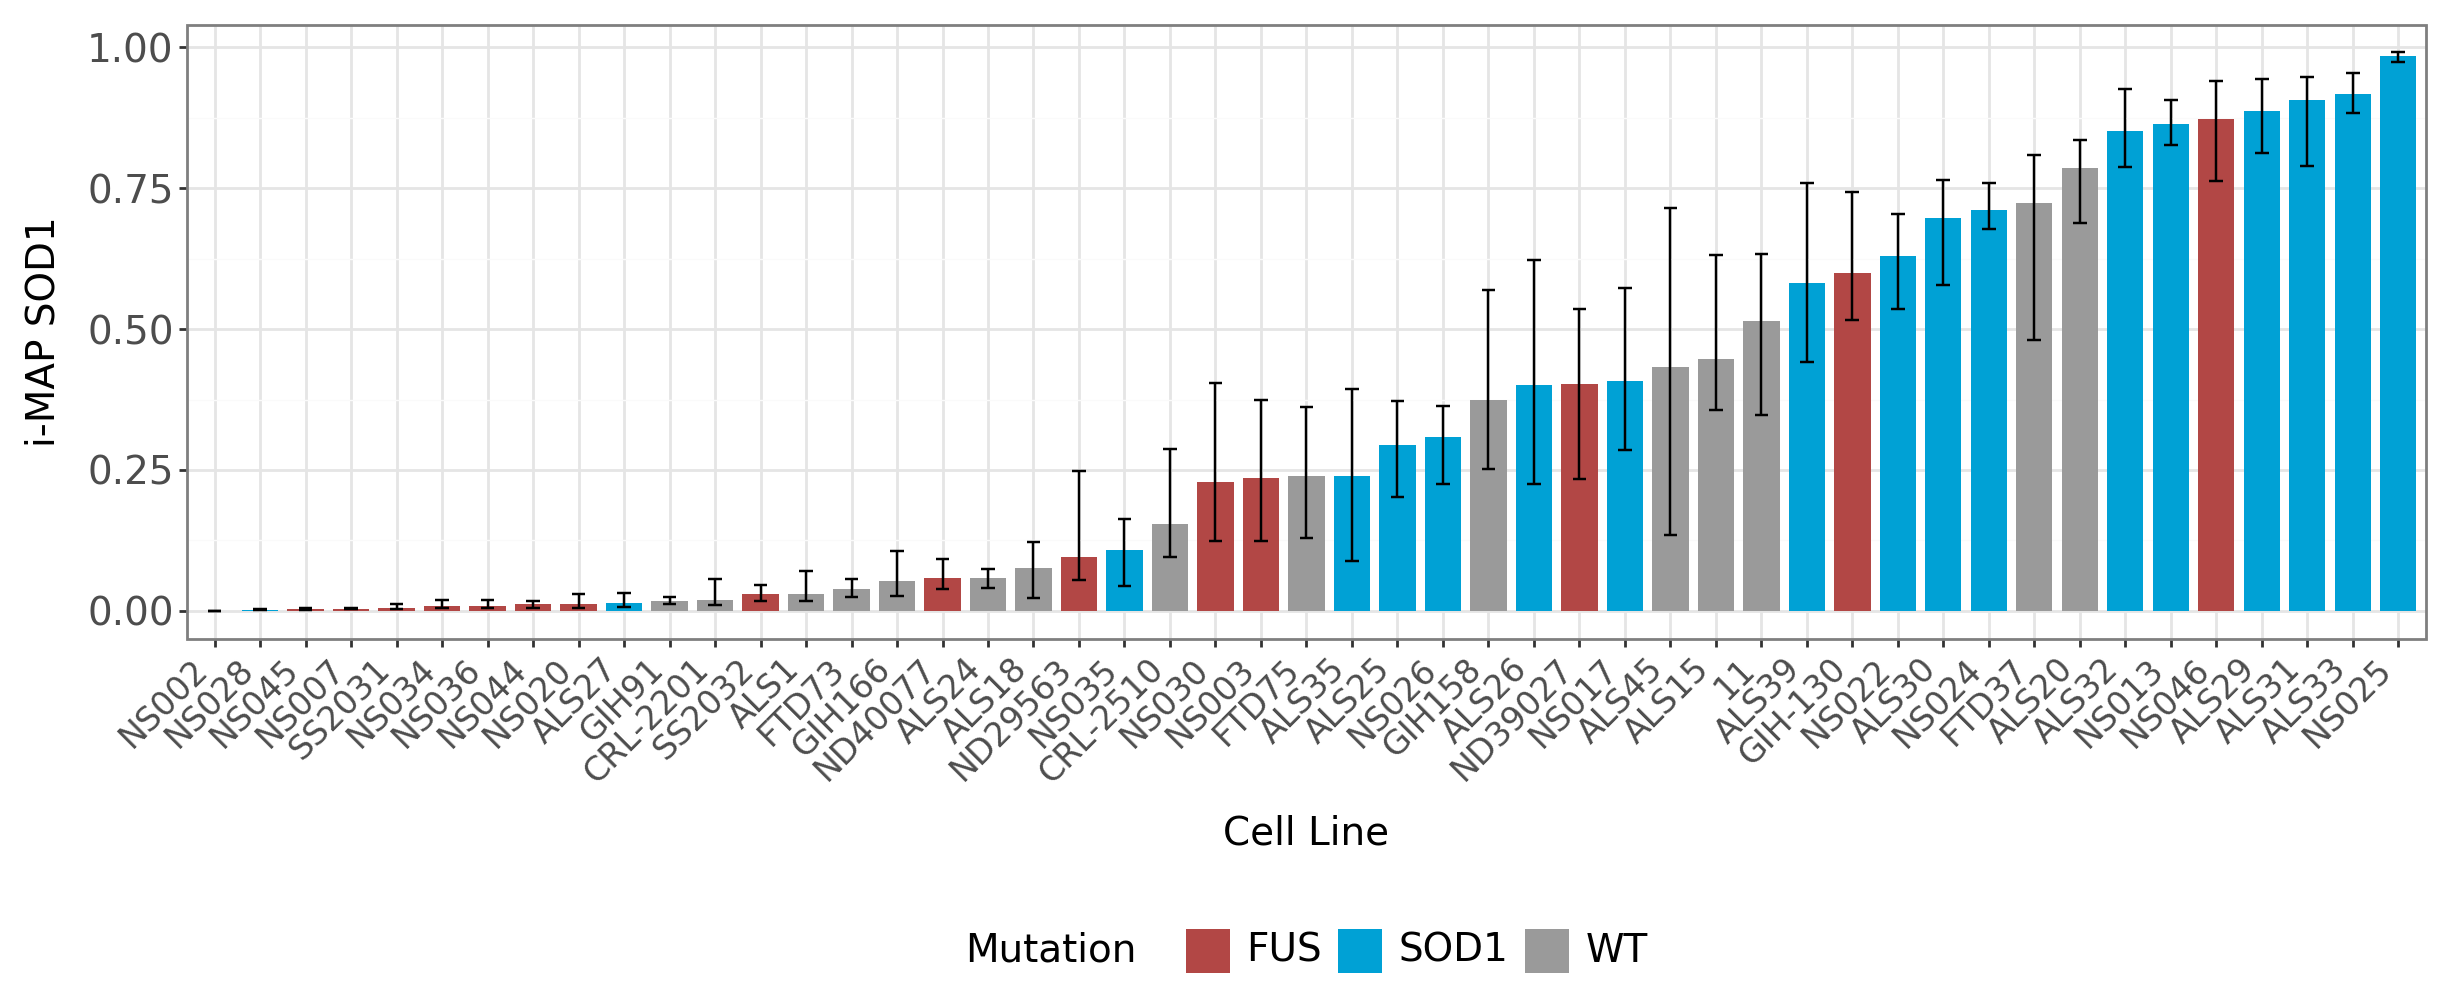

In [82]:
# Create bar plots showing average probability per class with error bars
from plotnine import *
from maps.figures import PALETTE
import numpy as np

# Add mutation labels to both df and df_full
class_names = {v: k for k, v in response_map.items()}
if 'Mutation' not in df.columns:
    df['Mutation'] = df['Label'].map(class_names)
df_full['Mutation'] = df_full['Label'].map(class_names)

# For each class, create a bar plot
for class_idx, class_name in class_names.items():
    prob_col = f'prob_{class_idx}'
    
    # Calculate statistics per cell line
    stats = df_full.groupby('CellLines').agg({
        prob_col: [('mean', 'mean'), ('min', 'min'), ('max', 'max')],
        'Mutation': 'first'
    }).reset_index()
    
    # Flatten column names
    stats.columns = ['CellLines', 'mean', 'min', 'max', 'Mutation']
    
    # Calculate error bar ranges
    stats['error_low'] = stats['mean'] - stats['min']
    stats['error_high'] = stats['max'] - stats['mean']
    
    # Sort by mean probability (low to high)
    stats = stats.sort_values('mean')
    stats['CellLines'] = pd.Categorical(
        stats['CellLines'], 
        categories=stats['CellLines'].tolist(), 
        ordered=True
    )
    
    # Create bar plot
    p = (
        ggplot(stats, aes(x='CellLines', y='mean', fill='Mutation')) +
        geom_col(width=0.8) +
        geom_errorbar(aes(ymin='mean - error_low', ymax='mean + error_high'), 
                     width=0.3, size=0.5) +
        scale_fill_manual(values=PALETTE, name='Mutation') +
        theme_bw() +
        theme(
            text=element_text(size=14),
            figure_size=(max(10, len(stats) * 0.25), 5),
            axis_text_x=element_text(angle=45, hjust=1, size=12),
            legend_position='bottom'
        ) +
        labs(
            title='',
            x='Cell Line',
            y=f'i-MAP {class_name}'
        ) +
        guides(fill=guide_legend(ncol=len(response_map)))
    )
    
    display(p)

In [92]:
# Create PCA visualization with percentile-based uncertainty visualization
from plotnine import *
from maps.figures import PALETTE
from sklearn.decomposition import PCA
import numpy as np

import matplotlib.pyplot as plt

# Map Label to mutation names for both datasets
df_avg = df.copy()
class_names = {v: k for k, v in response_map.items()}
df_avg['Mutation'] = df_avg['Label'].map(class_names)

# Fit PCA on the averaged data (df)
probs = [f"prob_{i}" for i in range(len(class_names))]
prob_data_avg = df_avg[probs].values
pca = PCA(n_components=2, random_state=42)
pca_avg = pca.fit_transform(prob_data_avg)


# Add PCA coordinates to dataframes
df_avg['PCA1'] = pca_avg[:, 0]
df_avg['PCA2'] = pca_avg[:, 1]

# Transform grid points to PCA space and compute convex hulls
from scipy.spatial import ConvexHull

grid_hull_list = []
threshold_labels = {
    conformal_qts.iloc[0]: '75% confidence region',
    conformal_qts.iloc[1]: '90% confidence region'
}

# Map quantile thresholds to alpha levels
alpha_map = {
    conformal_qts.iloc[0]: 0.3,  # 75% -> lighter
    conformal_qts.iloc[1]: 0.6   # 90% -> darker
}

for (qt, col_idx), grid_df in grid_dict.items():
    grid_probs = grid_df[prob_cols].values
    grid_pca = pca.transform(grid_probs)
    
    # Compute convex hull
    try:
        hull = ConvexHull(grid_pca)
        hull_points = grid_pca[hull.vertices]
        
        # Map column index to mutation name for coloring
        class_name = class_names[col_idx]
        
        # Create dataframe with hull vertices
        hull_df = pd.DataFrame({
            'PCA1': hull_points[:, 0],
            'PCA2': hull_points[:, 1],
            'threshold': qt,
            'threshold_col': col_idx,
            'Mutation': class_name,  # For color mapping
            'Confidence': threshold_labels[qt],  # For legend
            'alpha': alpha_map[qt],  # For alpha mapping
            'group': f'{qt:.3f}_col{col_idx}'  # Unique group identifier
        })
        grid_hull_list.append(hull_df)
    except Exception as e:
        print(f"Could not compute hull for qt={qt}, col={col_idx}: {e}")

grid_hull_all = pd.concat(grid_hull_list, ignore_index=True)

# Create PCA plot with convex hull polygons and centroids
p_pca = (
    ggplot() +
    geom_polygon(
        data=grid_hull_all, 
        mapping=aes(x='PCA1', y='PCA2', fill='Mutation', alpha='Confidence', group='group'), 
        color=None) +
    geom_point(
        data=df_avg, 
        mapping=aes(x='PCA1', y='PCA2', color='Mutation'), 
        size=4) +
    scale_fill_manual(values=PALETTE, name='') +
    scale_color_manual(values=PALETTE, name='') +
    scale_alpha_manual(values=[0.3, 0.6], name='') +
    theme_bw() +
    theme(
        text=element_text(size=22),
        figure_size=(12, 8),
        legend_position='right'
    ) +
    labs(
        title=f'PCA of multiclass i-MAP scores',
        x=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        y=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
    ) +
    guides(
        fill=guide_legend(override_aes={'alpha': 0.5}, order=1),
        color=False,
        alpha=guide_legend(override_aes={'fill': 'gray'}, order=2)
    )
)

display(p_pca)

#fig = p_pca.draw()
#fig.savefig(result_dir / "coords.eps", format='eps')  # Works on all platforms
#plt.close(fig)
#p_pca.save(result_dir / "coords.svg", format="svg")
#ggsave(p_pca, result_dir / "coords.svg")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Could not compute hull for qt=0.7702801794233457, col=3: 3
Could not compute hull for qt=0.9305941051160787, col=3: 3


In [93]:
# Create PCA visualization including sporadic samples
from plotnine import *
from maps.figures import PALETTE
from sklearn.decomposition import PCA
import numpy as np

# Process sporadic data
df_sporadic_avg = df_sporadic.copy()
df_sporadic_avg['Mutation'] = 'sporadic'

# Get average probabilities for sporadic samples
prob_data_sporadic = df_sporadic_avg[prob_cols].values
pca_sporadic = pca.transform(prob_data_sporadic)

# Add PCA coordinates
df_sporadic_avg['PCA1'] = pca_sporadic[:, 0]
df_sporadic_avg['PCA2'] = pca_sporadic[:, 1]

# Create extended color palette including sporadic
PALETTE_EXTENDED = PALETTE.copy()
PALETTE_EXTENDED['sporadic'] = 'black'  # Gray for sporadic

# Create PCA plot with centroids, sporadic samples, and convex hull polygons
p_pca_with_sporadic = (
    ggplot() +
    geom_polygon(
        data=grid_hull_all, 
        mapping=aes(x='PCA1', y='PCA2', fill='Mutation', alpha='Confidence', group='group'), 
        color=None) +
    geom_point(
        data=df_avg, 
        mapping=aes(x='PCA1', y='PCA2', color='Mutation'), 
        size=4) +
    geom_point(
        data=df_sporadic_avg, 
        mapping=aes(x='PCA1', y='PCA2', color='Mutation'), 
        size=4, shape='x', stroke=2, show_legend=False) +
    scale_fill_manual(values=PALETTE_EXTENDED, name='') +
    scale_color_manual(values=PALETTE_EXTENDED, name='') +
    scale_alpha_manual(values=[0.3, 0.6], name='') +
    theme_bw() +
    theme(
        text=element_text(size=22),
        figure_size=(12, 8),
        legend_position='right'
    ) +
    labs(
        title=f'PCA of multiclass i-MAP scores',
        x=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        y=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
    ) +
    guides(
        fill=guide_legend(override_aes={'alpha': 0.5}, order=1),
        color=False,
        alpha=guide_legend(override_aes={'fill': 'gray'}, order=2)
    )
)

#display(p_pca_with_sporadic)

fig = p_pca_with_sporadic.draw()
fig.savefig(result_dir / "coords_sporadic.eps", format='eps')  # Works on all platforms
plt.close(fig)

#p_pca_with_sporadic.save(result_dir / "coords_sporadic.svg", format="svg")
#ggsave(p_pca_with_sporadic, result_dir / "coords_sporadic.svg")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


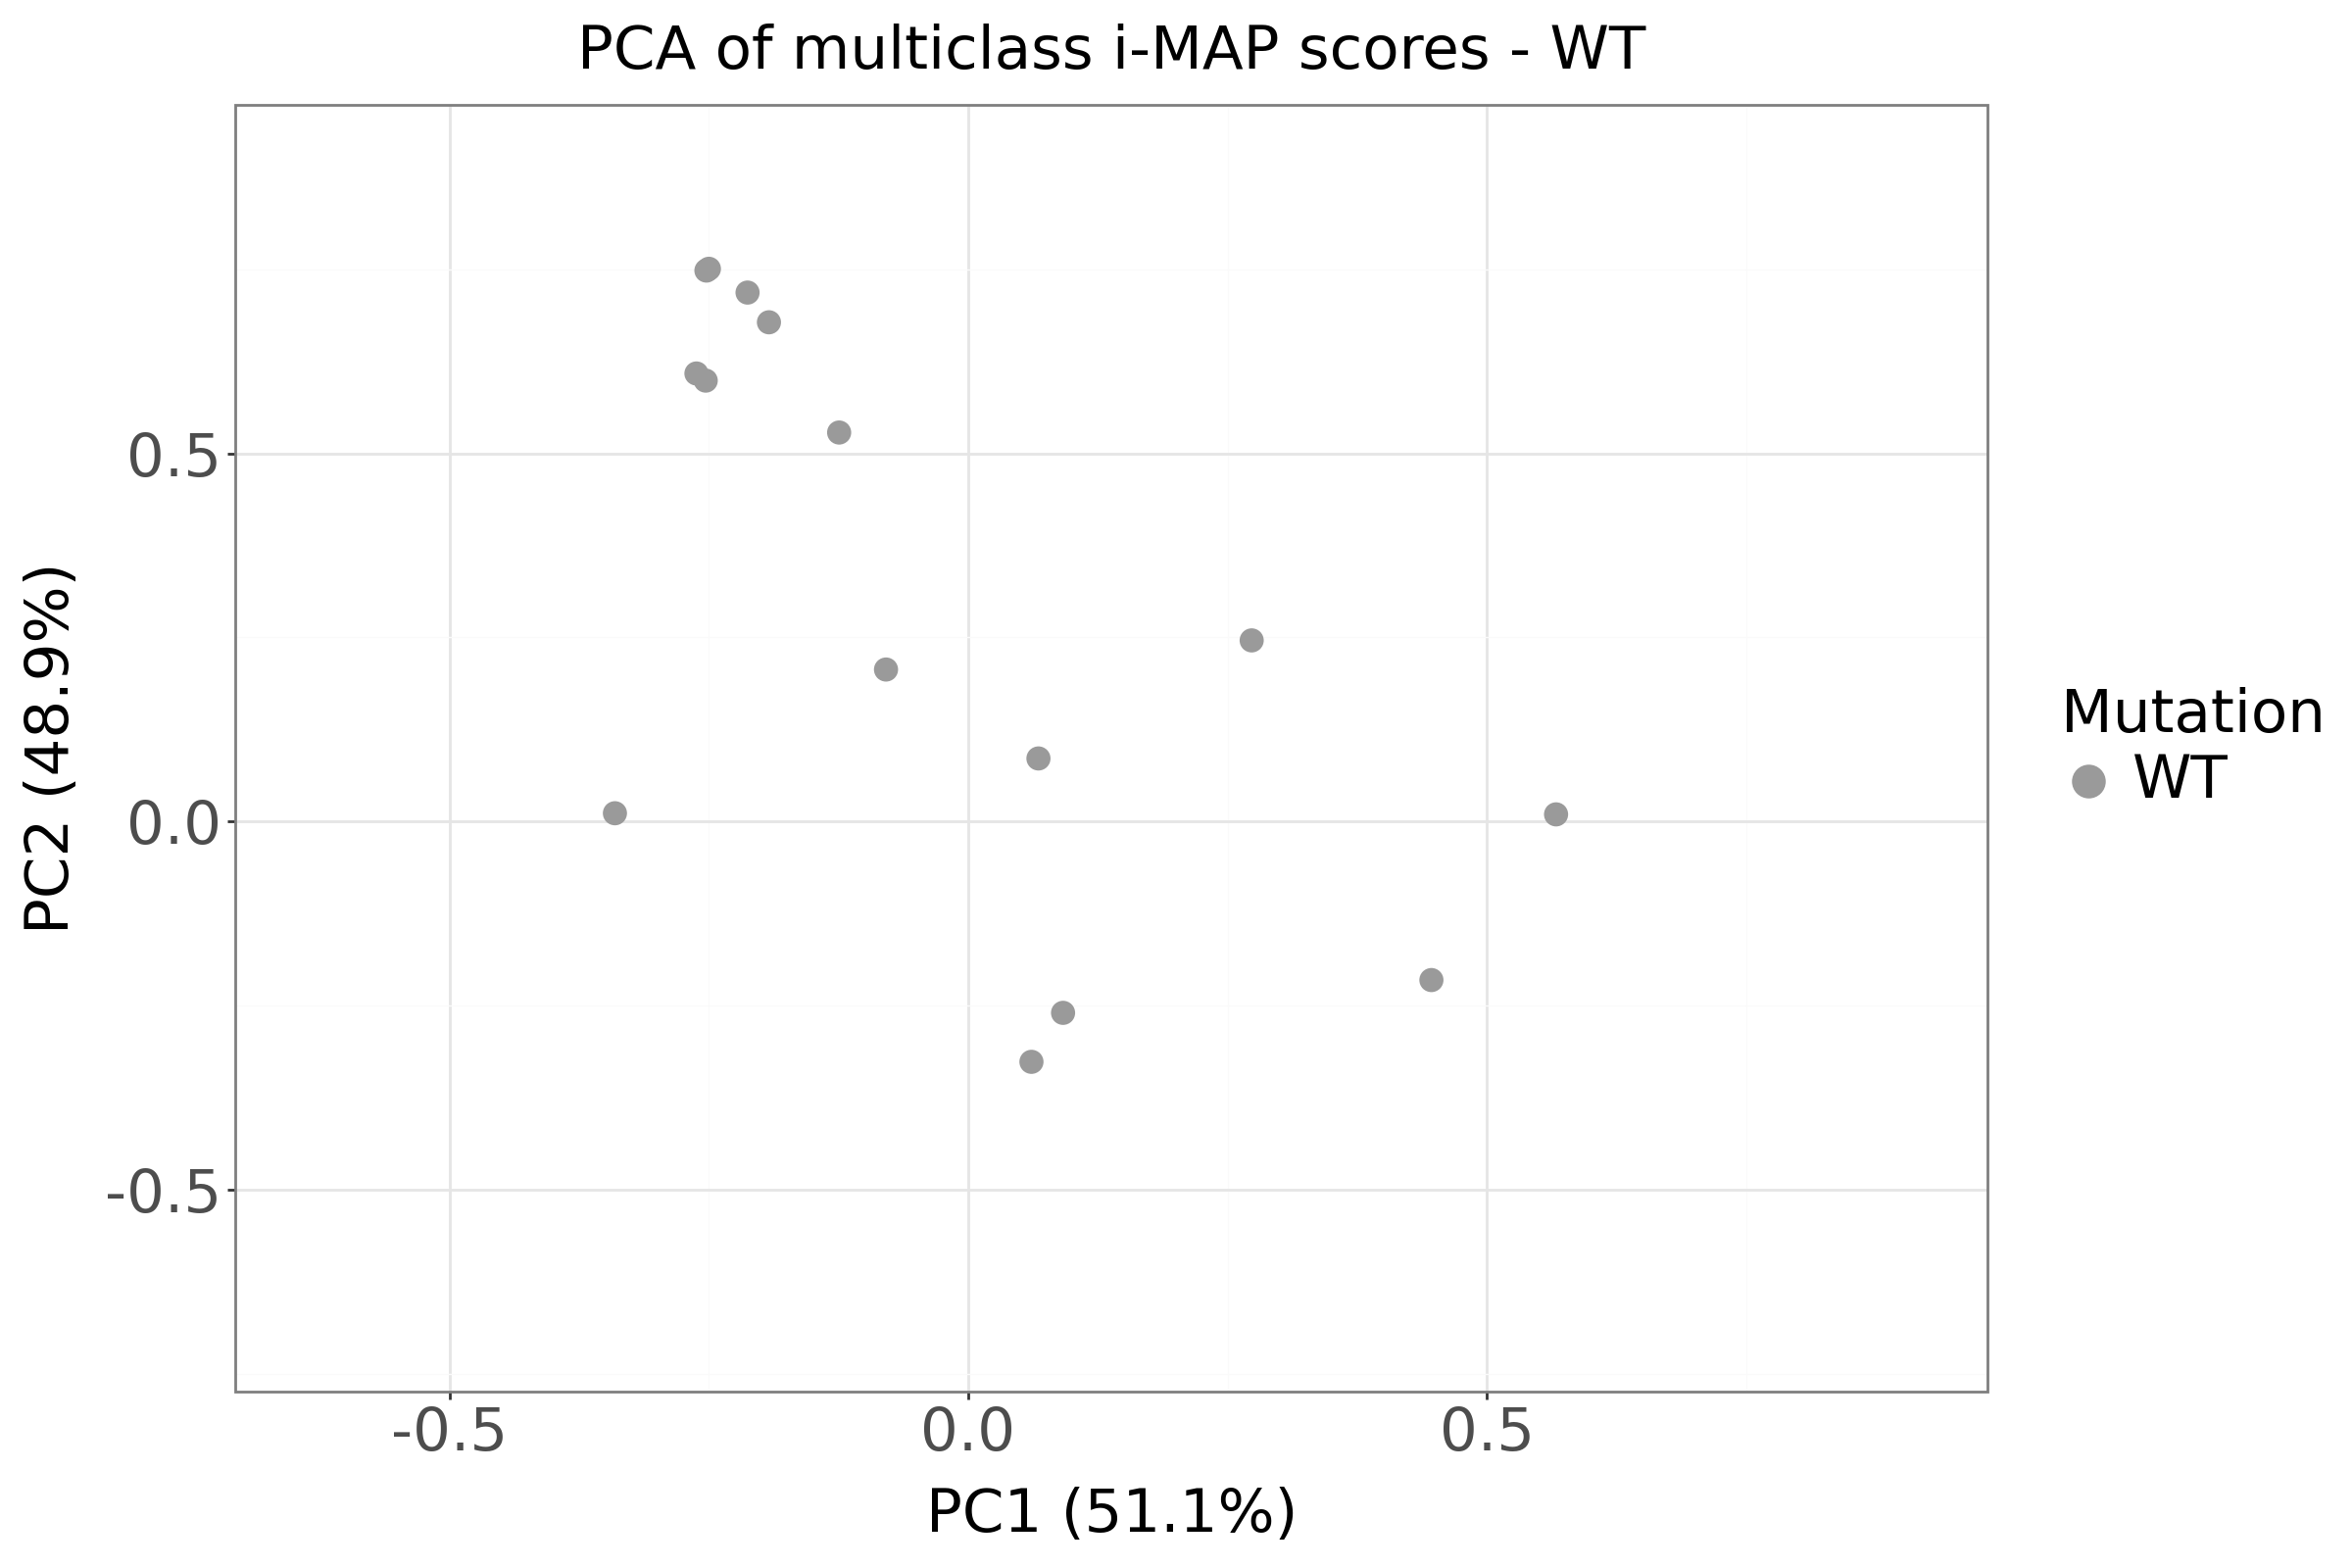

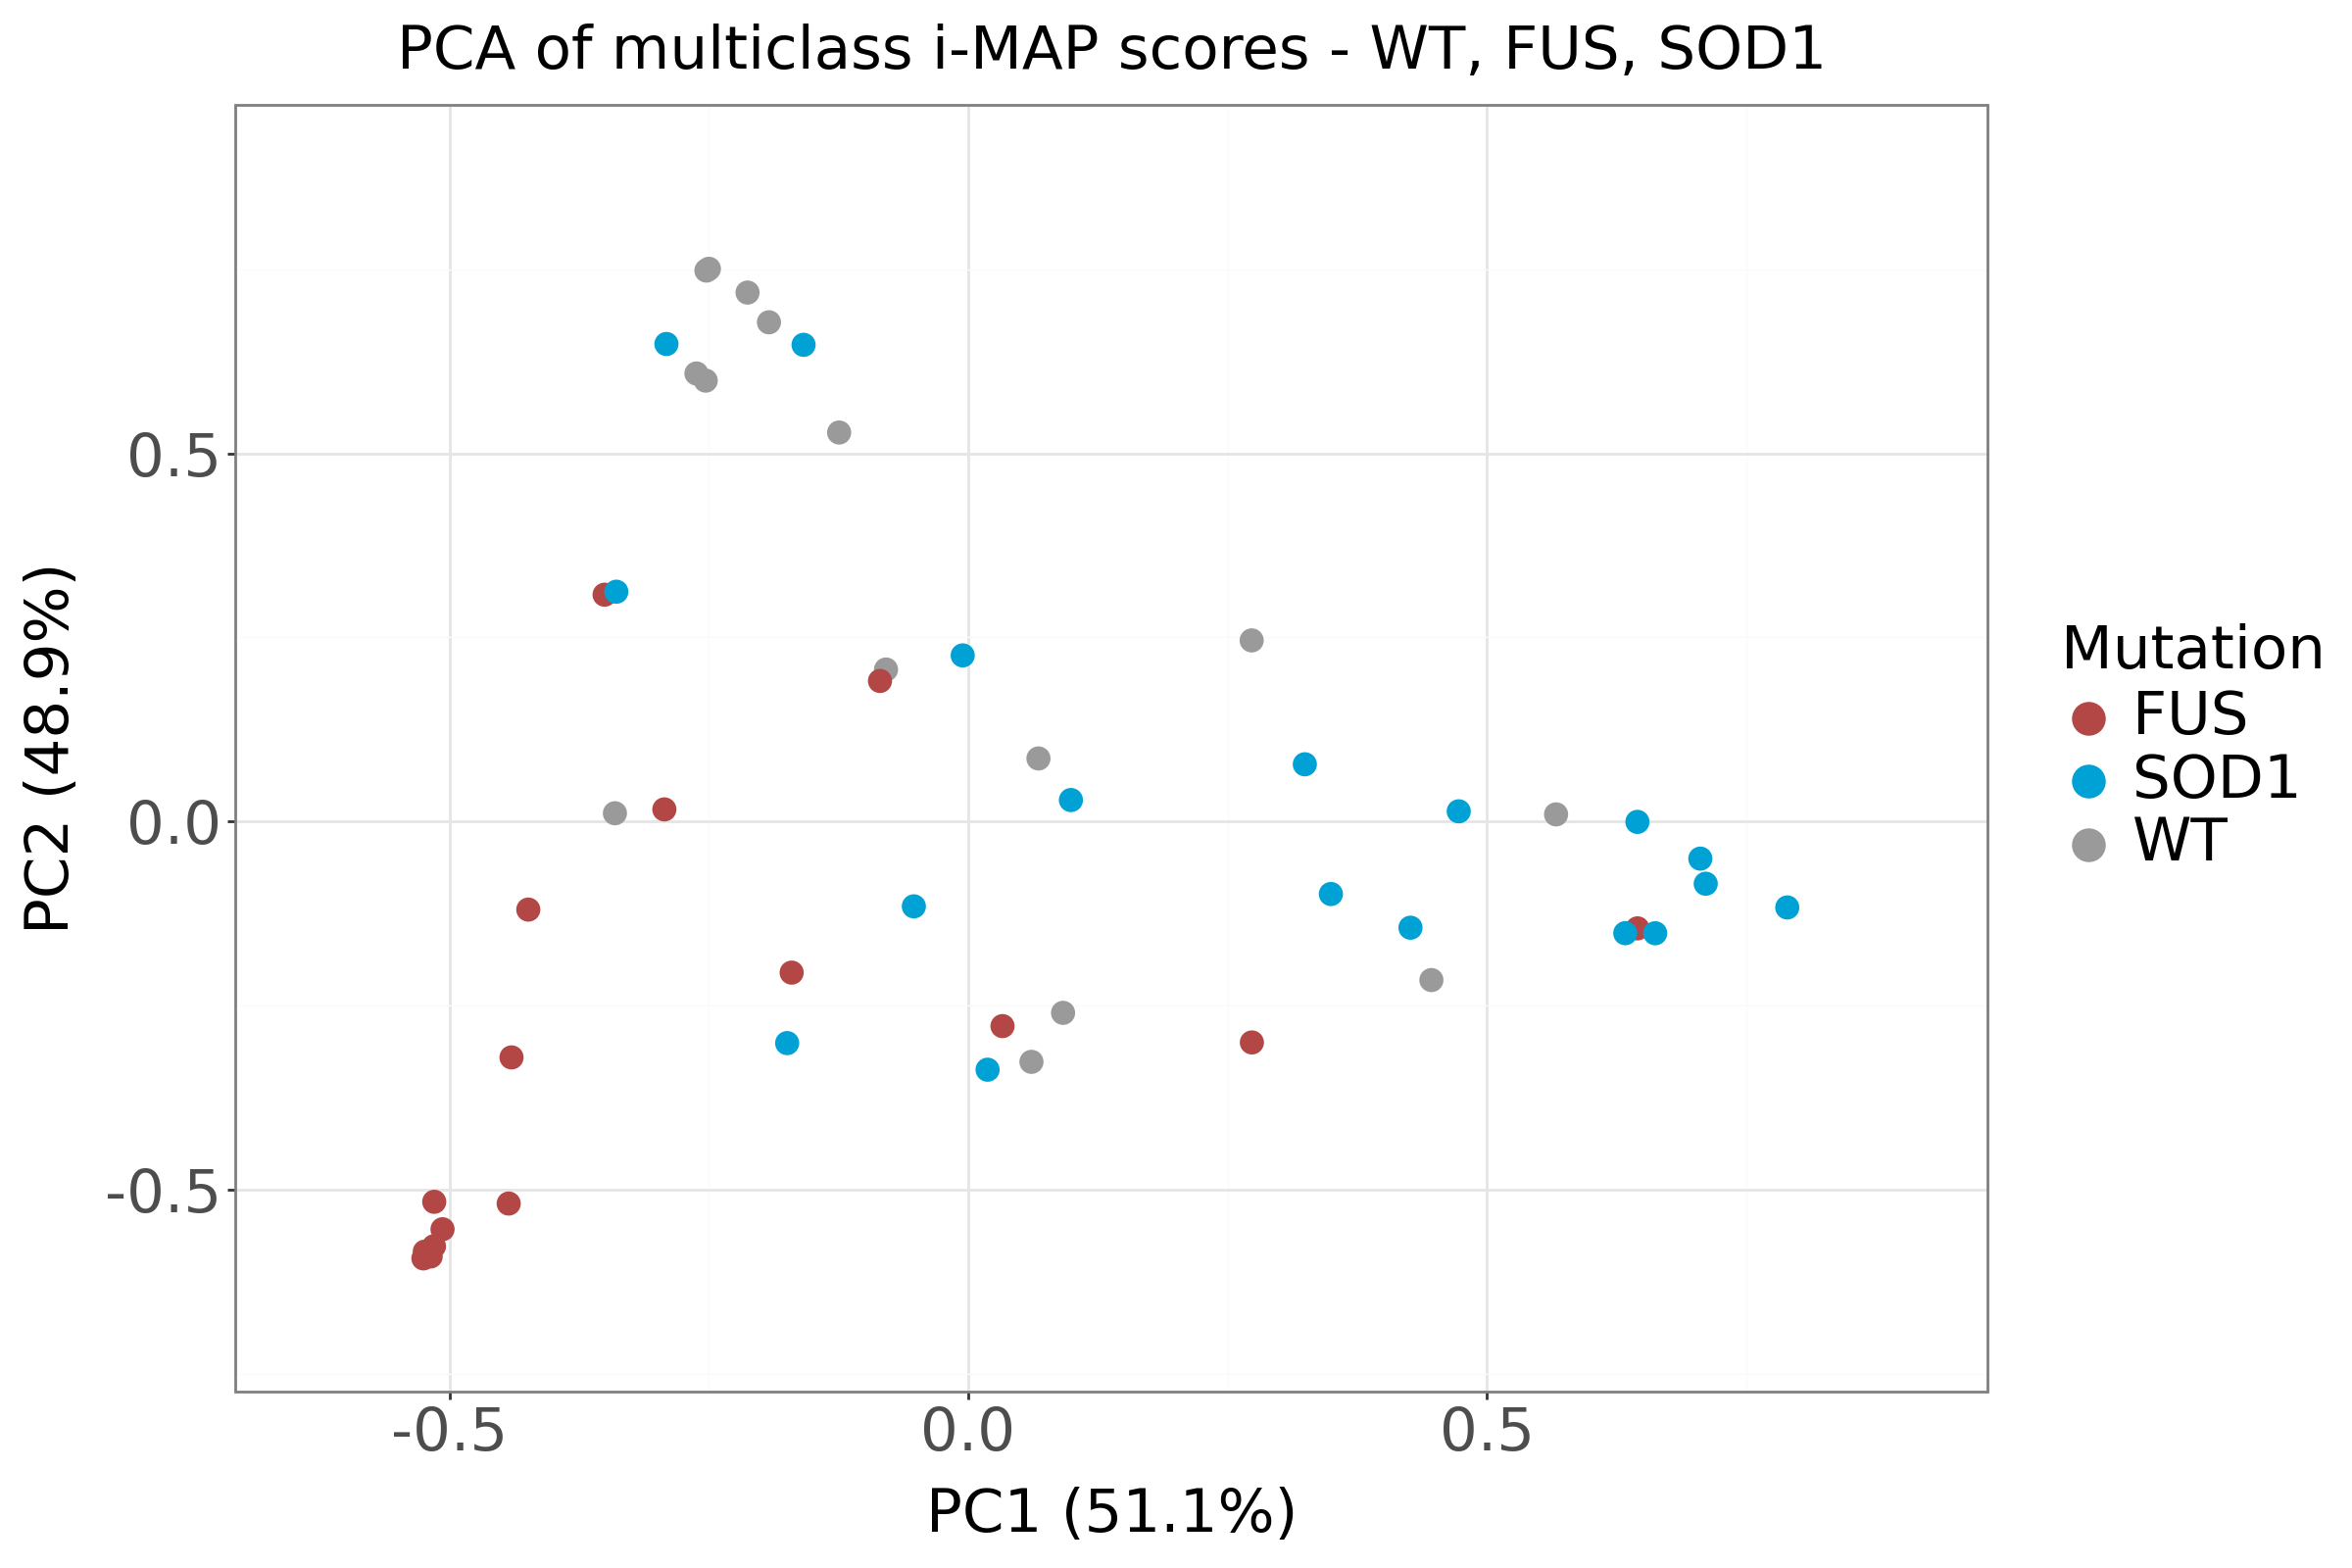

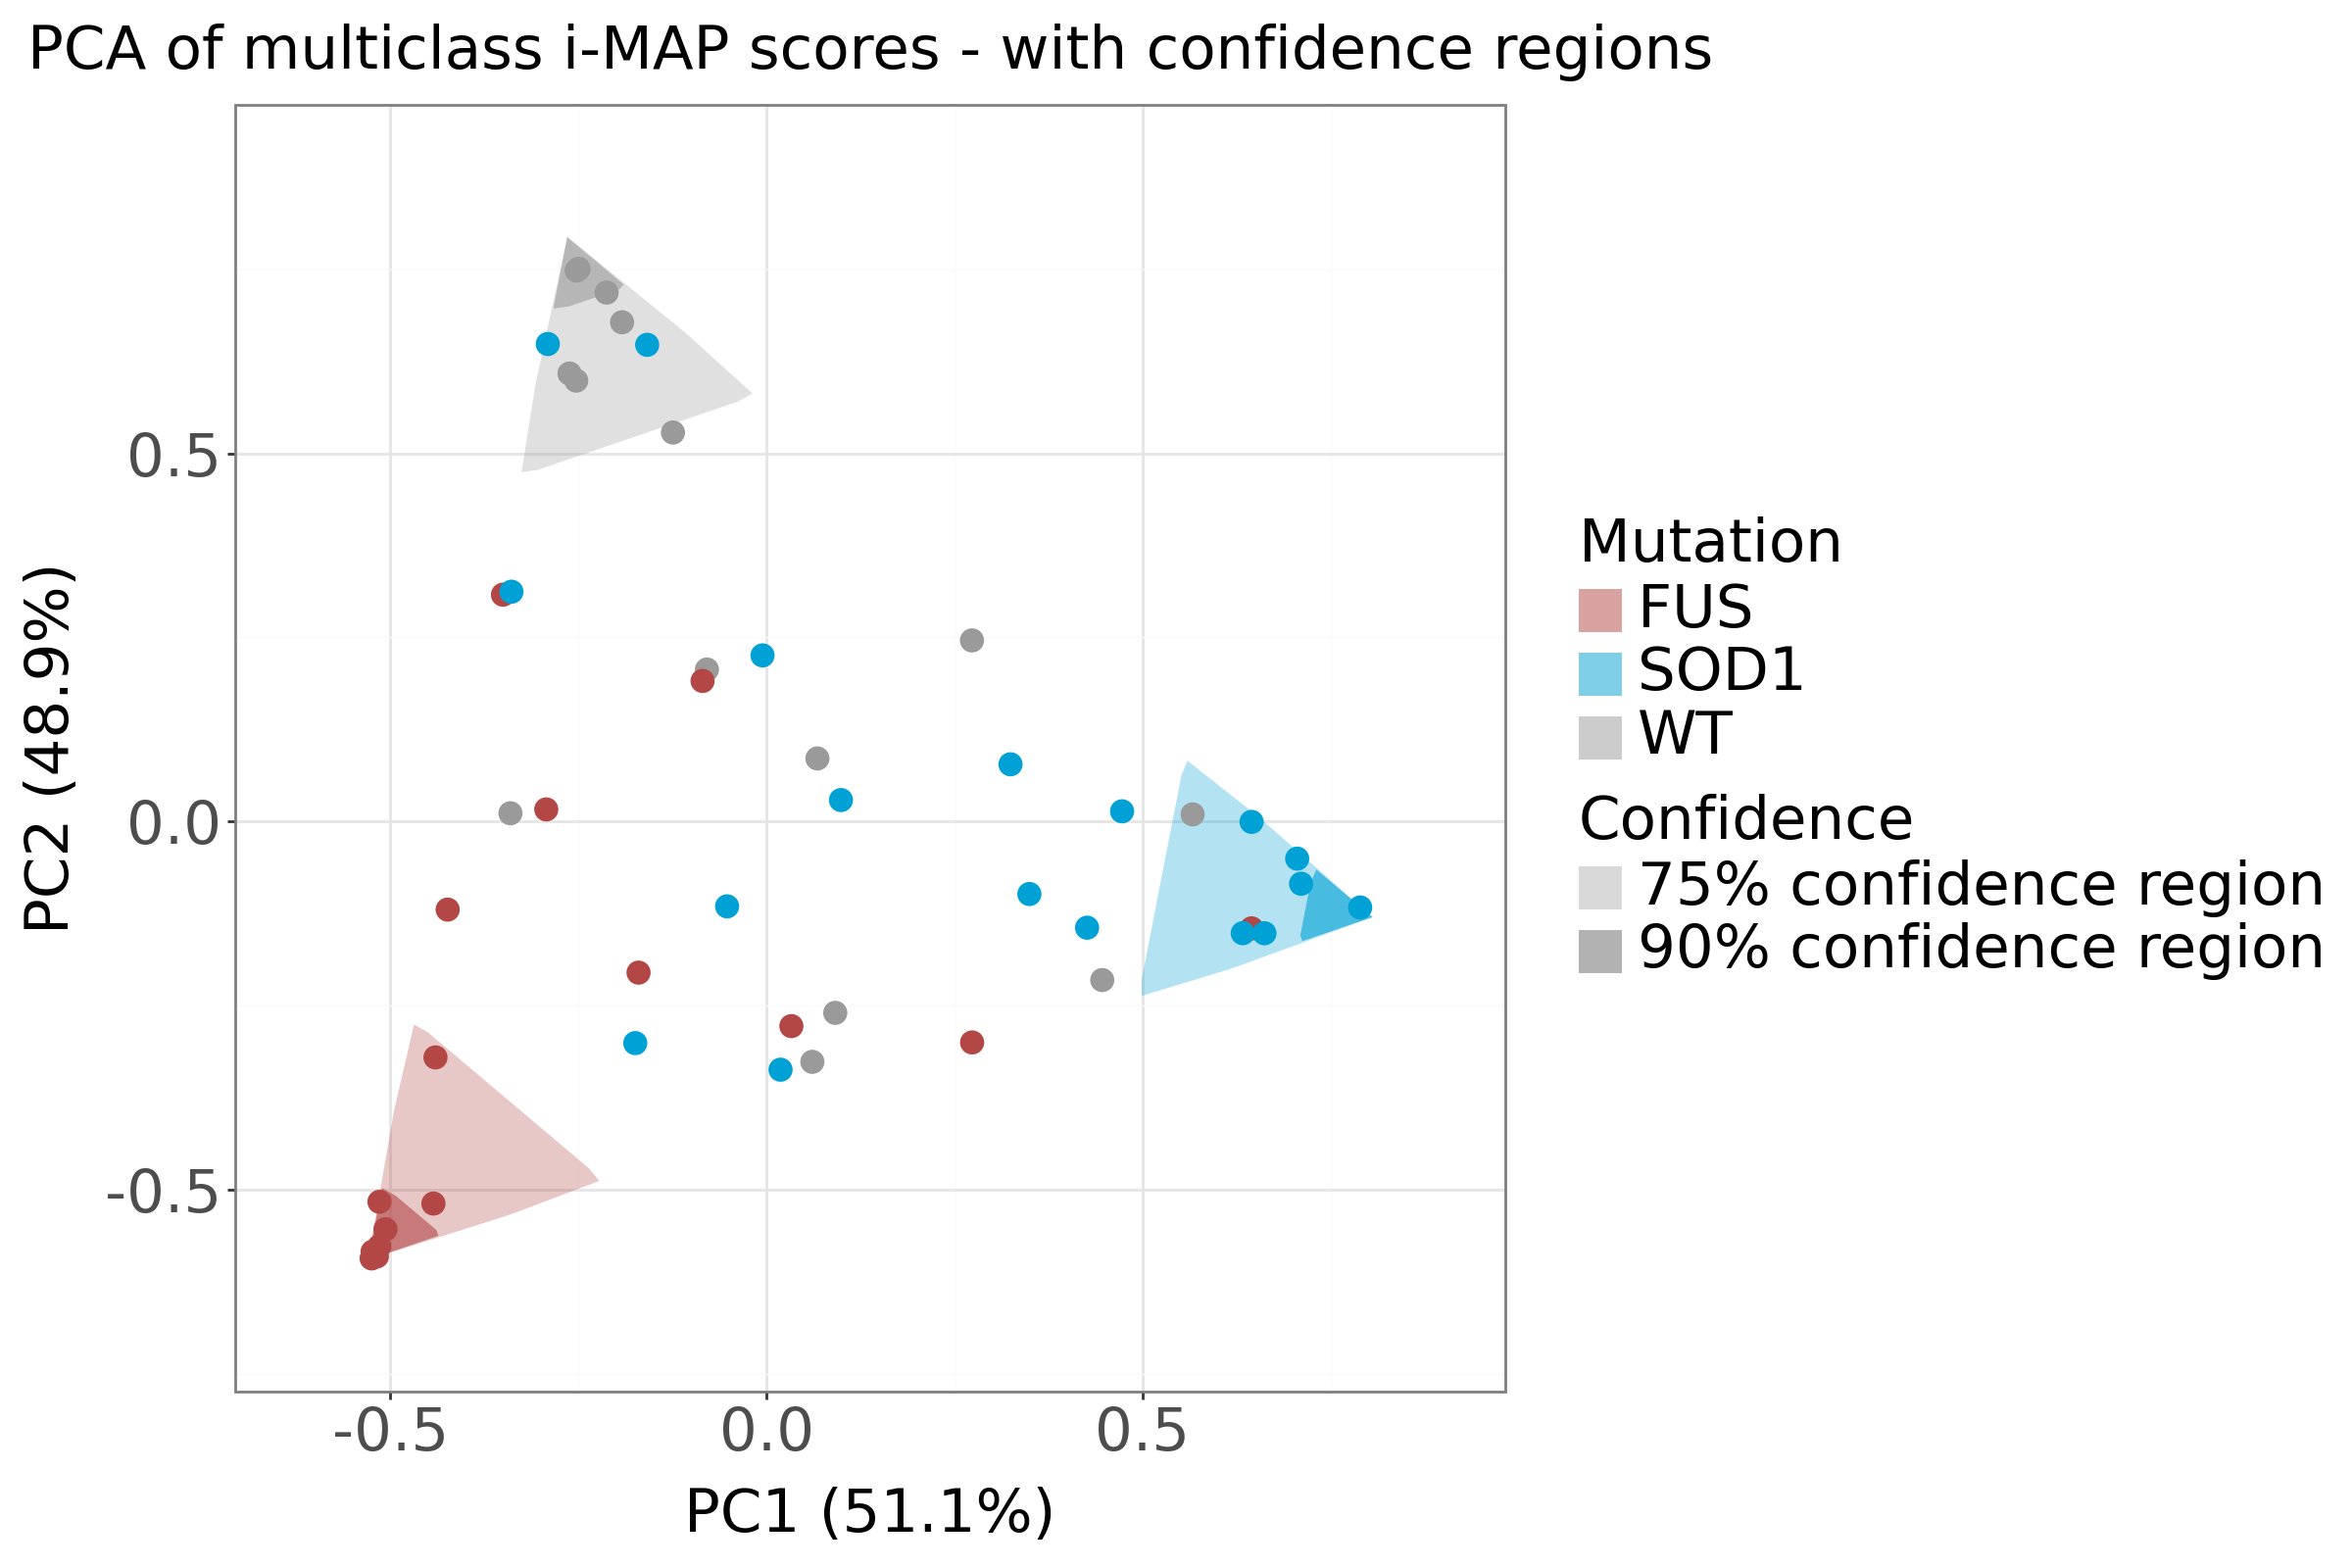

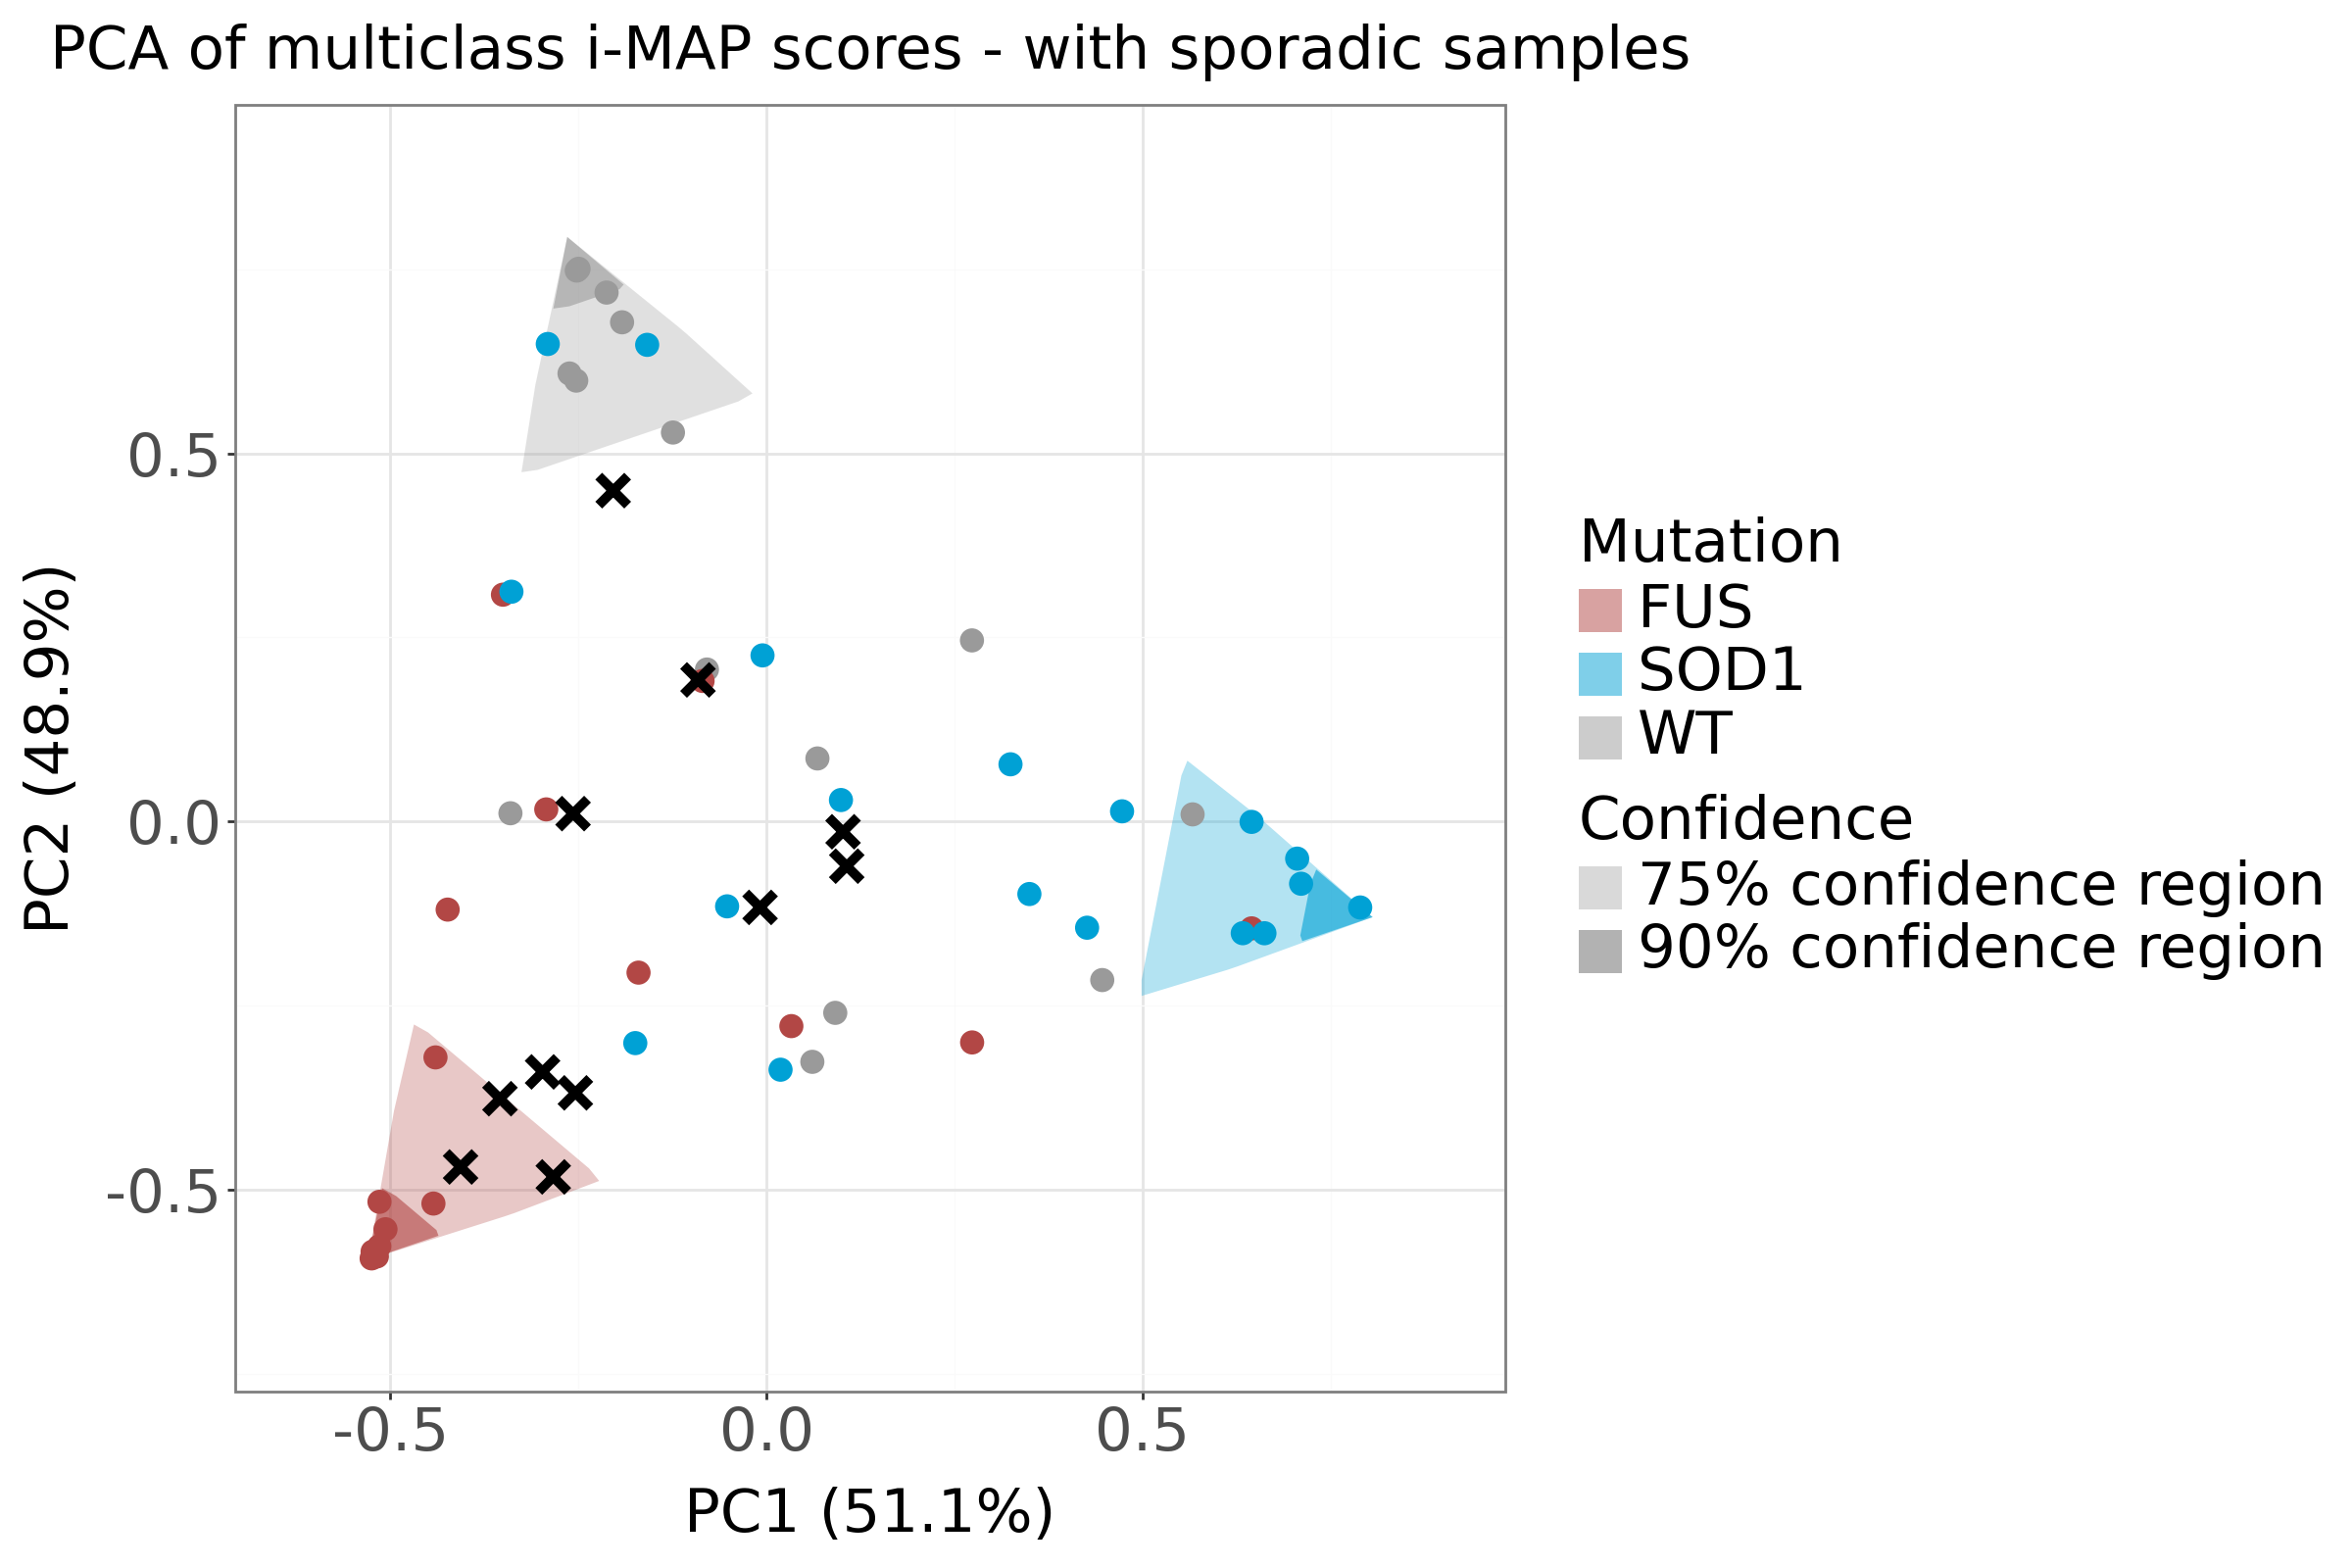

In [94]:
# Sequential PCA plots - building up the visualization step by step
from plotnine import *
from maps.figures import PALETTE
import matplotlib.pyplot as plt

# Determine plot limits from all data to keep consistent across plots
all_pca1 = list(df_avg['PCA1']) + list(grid_hull_all['PCA1']) + list(df_sporadic_avg['PCA1'])
all_pca2 = list(df_avg['PCA2']) + list(grid_hull_all['PCA2']) + list(df_sporadic_avg['PCA2'])
xlim = (min(all_pca1) - 0.1, max(all_pca1) + 0.1)
ylim = (min(all_pca2) - 0.1, max(all_pca2) + 0.1)

# Plot 1: WT points only
df_wt = df_avg[df_avg['Mutation'] == 'WT'].copy()

p1 = (
    ggplot() +
    geom_point(
        data=df_wt, 
        mapping=aes(x='PCA1', y='PCA2', color='Mutation'), 
        size=4) +
    scale_color_manual(values=PALETTE, name='') +
    scale_x_continuous(limits=xlim) +
    scale_y_continuous(limits=ylim) +
    theme_bw() +
    theme(
        text=element_text(size=22),
        figure_size=(12, 8),
        legend_position='right'
    ) +
    labs(
        title='PCA of multiclass i-MAP scores - WT',
        x=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        y=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
    ) +
    guides(
        color=guide_legend(override_aes={'size': 6})
    )
)

display(p1)

# Plot 2: Add FUS and SOD1 points
df_wt_fus_sod1 = df_avg[df_avg['Mutation'].isin(['WT', 'FUS', 'SOD1'])].copy()

p2 = (
    ggplot() +
    geom_point(
        data=df_wt_fus_sod1, 
        mapping=aes(x='PCA1', y='PCA2', color='Mutation'), 
        size=4) +
    scale_color_manual(values=PALETTE, name='') +
    scale_x_continuous(limits=xlim) +
    scale_y_continuous(limits=ylim) +
    theme_bw() +
    theme(
        text=element_text(size=22),
        figure_size=(12, 8),
        legend_position='right'
    ) +
    labs(
        title='PCA of multiclass i-MAP scores - WT, FUS, SOD1',
        x=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        y=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
    ) +
    guides(
        color=guide_legend(override_aes={'size': 6})
    )
)

display(p2)

# Plot 3: Add confidence regions
p3 = (
    ggplot() +
    geom_polygon(
        data=grid_hull_all, 
        mapping=aes(x='PCA1', y='PCA2', fill='Mutation', alpha='Confidence', group='group'), 
        color=None) +
    geom_point(
        data=df_avg, 
        mapping=aes(x='PCA1', y='PCA2', color='Mutation'), 
        size=4) +
    scale_fill_manual(values=PALETTE, name='') +
    scale_color_manual(values=PALETTE, name='') +
    scale_alpha_manual(values=[0.3, 0.6], name='') +
    scale_x_continuous(limits=xlim) +
    scale_y_continuous(limits=ylim) +
    theme_bw() +
    theme(
        text=element_text(size=22),
        figure_size=(12, 8),
        legend_position='right'
    ) +
    labs(
        title='PCA of multiclass i-MAP scores - with confidence regions',
        x=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        y=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
    ) +
    guides(
        fill=guide_legend(override_aes={'alpha': 0.5}, order=1),
        color=False,
        alpha=guide_legend(override_aes={'fill': 'gray'}, order=2)
    )
)

display(p3)

# Plot 4: Add sporadic samples
p4 = (
    ggplot() +
    geom_polygon(
        data=grid_hull_all, 
        mapping=aes(x='PCA1', y='PCA2', fill='Mutation', alpha='Confidence', group='group'), 
        color=None) +
    geom_point(
        data=df_avg, 
        mapping=aes(x='PCA1', y='PCA2', color='Mutation'), 
        size=4) +
    geom_point(
        data=df_sporadic_avg, 
        mapping=aes(x='PCA1', y='PCA2', color='Mutation'), 
        size=4, shape='x', stroke=2, show_legend=False) +
    scale_fill_manual(values=PALETTE_EXTENDED, name='') +
    scale_color_manual(values=PALETTE_EXTENDED, name='') +
    scale_alpha_manual(values=[0.3, 0.6], name='') +
    scale_x_continuous(limits=xlim) +
    scale_y_continuous(limits=ylim) +
    theme_bw() +
    theme(
        text=element_text(size=22),
        figure_size=(12, 8),
        legend_position='right'
    ) +
    labs(
        title='PCA of multiclass i-MAP scores - with sporadic samples',
        x=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        y=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
    ) +
    guides(
        fill=guide_legend(override_aes={'alpha': 0.5}, order=1),
        color=False,
        alpha=guide_legend(override_aes={'fill': 'gray'}, order=2)
    )
)

display(p4)